# `Method 1` : Data Augumentation using Keras Layers

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import cifar10

Original Images :
 


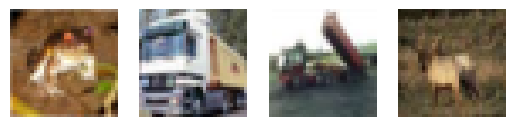

Resized Images : 



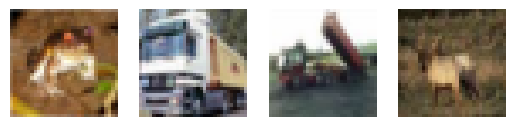

Augumented Images : 



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


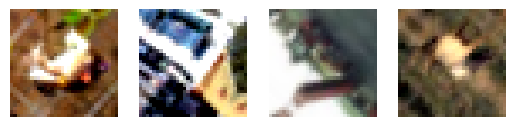

Prepared Dataset Images : 


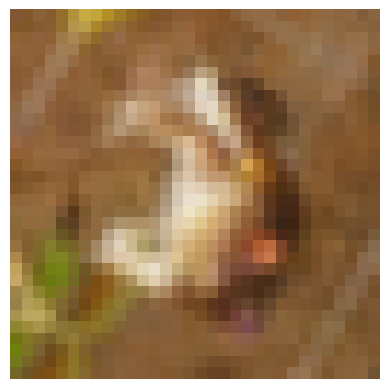

In [4]:

train_ds,test_ds = cifar10.load_data()
train_ds = tf.data.Dataset.from_tensor_slices(train_ds)

def show_images(images):
    n = len(images)
    for i,image in enumerate(images):
        plt.subplot(1,n,i+1)
        plt.imshow(image)
        plt.axis("off")
    plt.show()

print("Original Images :\n ")
show_images(train_ds.take(4).map(lambda x,y:x))

IMG_SIZE = 32

resize_and_rescale = tf.keras.Sequential([
    tf.keras.layers.Resizing(IMG_SIZE,IMG_SIZE),
    tf.keras.layers.Rescaling(1./256)
])

resized_images = train_ds.take(4).map(lambda x,y : resize_and_rescale(x))
print("Resized Images : \n")
show_images(resized_images)

data_augumentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip(),
    tf.keras.layers.RandomRotation(factor=0.2),
    tf.keras.layers.RandomContrast(factor=(0.2,0.9))
])

aug_images = resized_images.map(lambda x : data_augumentation(x))
print("Augumented Images : \n")
show_images(aug_images)

def prepare(ds):
    AUTO_TUNE = tf.data.AUTOTUNE
    ds = ds.map(lambda x,y : (resize_and_rescale(x),y),num_parallel_calls = AUTO_TUNE)
    ds = ds.map(lambda x,y : (data_augumentation(x),y),num_parallel_calls = AUTO_TUNE)
    return ds.prefetch(buffer_size = AUTO_TUNE)

print("Prepared Dataset Images : ")
prepared_ds  = prepare(train_ds.take(1))
show_images(prepared_ds.map(lambda x,y : x))

# `Method 2` : Using Tensorflow.image

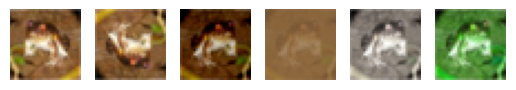

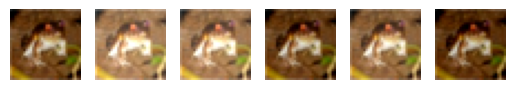

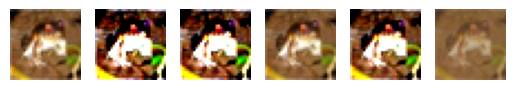

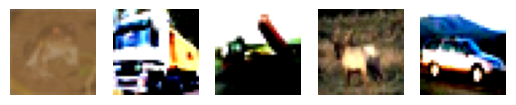

In [7]:
image,label = next(iter(train_ds))

show_images([
    tf.image.flip_left_right(image),
    tf.image.flip_up_down(image),
    tf.image.adjust_brightness(image,-.2),
    tf.image.adjust_contrast(image,.2),
    tf.image.adjust_saturation(image,.2),
    tf.image.adjust_hue(image,.2)
])

show_images([
    tf.image.stateless_random_brightness(image,max_delta=0.2,seed=(i,0)) for i in range(0,6)
])

show_images([
    tf.image.stateless_random_contrast(image,lower=0.2,upper=5,seed=(i,0)) for i in range(0,6)
])

def resize_and_rescale(image):
    img = tf.cast(image,tf.float32)
    img = tf.image.resize(img,size=(IMG_SIZE,IMG_SIZE))
    img = img/255.0
    return img

def aug_img(image_label,seed):
    image,label  = image_label
    img = resize_and_rescale(image)
    img = tf.image.stateless_random_crop(img,size=[IMG_SIZE,IMG_SIZE,3],seed=seed)
    img = tf.image.stateless_random_contrast(img,lower=0.2,upper=5,seed=seed)
    img = tf.clip_by_value(img,0,1)
    return img,label

rng = tf.random.Generator.from_seed(1)

def wrapper(image,label):
    seed = rng.make_seeds(2)[0]
    image,label = aug_img((image,label),seed)
    return image,label

aug_images = train_ds.take(5).map(wrapper)
show_images(aug_images.map(lambda x,y : x))